# Plot particles position and variable map

This is a basic tutorial on Pyticles Postprocessing.

Example is based on gigatl6 croco simulation and a Pyticle experiment linked to 
eurec4a Project.

Files may be available on datarmor computing center.

## Setting up environment

In addition to Pyticles core modules user shall compile Fortran tools to have 
access to more functions see `Docs/r-tools.md` for more information.

Also user should set up a conda environment with 
[xarray](https://docs.xarray.dev/en/stable/) (and [dask](https://www.dask.org/)). 
If not familiar with Xarray there is a nice 
[45 minutes tutorials available here](https://tutorial.xarray.dev/overview/xarray-in-45-min.html)

If dask and xarray are no option, dataset can be loaded using
classic netcdf library.

In [3]:
import sys
import matplotlib.pyplot as plt
#from netCDF4 import Dataset
import numpy as np
import numpy.ma as ma
import xarray as xr

# user definition: add path to your local Pyticles folder
# Pyticles tools shall be compiled in Modules
sys.path.append('/home2/datahome/jcollin/projects/Pyticles/Modules/')
sys.path.append('/home/datawork-lops-megatl/example_Jeremie/Pyticles_gigatl6_jeremie/Inputs/')

from R_files import load
# croco module
import R_vars as va
import R_tools as tools
from pyticles_sig_sa import map_var
#from input_file import *



In [4]:
# --> starts dask client: usefull only to heavy files
# note that this can make the notebook quite unstable therefore 
# save regularly and restart Kernell if necessary
from dask.distributed import Client, progress

client = Client()
client

/home2/datawork/jcollin/conda/envs/pyticles-pp-3.11/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 48163 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:48163/status,
Dashboard: http://127.0.0.1:48163/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56072,Workers: 4
Dashboard: http://127.0.0.1:48163/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:32919,Total threads: 1
Dashboard: http://127.0.0.1:35426/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:42362,


In [5]:
# --> loading (lazzily) Pyticles dataset
# file is loaded by chunk; be careful when setting chunk size (too big may lead to memory issues and 
# too small to CPU overhead and performance loss)
part_path = '/home/datawork-lops-megatl/example_Jeremie/Pyticles_gigatl6_jeremie/out'
part_file = part_path + '/gigatl6_1h_UP3_eurec4a_v0_28_2894.nc'

chunk_nq = 1e5
chunk_time = -1

ds = xr.open_dataset(
    part_file,
    chunks={
        "nq": chunk_nq,
        "time": chunk_time,
    },  # this tells xarray to open the dataset as a dask array)
  )


ds.info()

xarray.Dataset {
dimensions:
	time = 61 ;
	nq = 9380910 ;

variables:
	float32 ocean_time(time) ;
	float32 time(time) ;
	float64 px(time, nq) ;
	float64 py(time, nq) ;
	float64 pz(time, nq) ;
	float64 pt(time, nq) ;
	float64 ps(time, nq) ;
	float64 plon(time, nq) ;
	float64 plat(time, nq) ;
	float64 pdepth(time, nq) ;
	float64 ptopo(time, nq) ;
	float64 pu(time, nq) ;
	float64 pv(time, nq) ;
	float64 pw(time, nq) ;

// global attributes:
	:w_sed0 = -20 ;
	:meanflow = 0 ;
	:initial_depth = 1 ;
	:dfile = 1 ;
	:dx_box = 10000 ;
	:nx_box = 100 ;
	:ny_box = 100 ;
	:nqmx = 100000000 ;
	:nnlev = 1 ;
	:depths0 = [-2000 -1900 -1800 -1700 -1600 -1500 -1400 -1300 -1200 -1100 -1000  -900
  -800  -700  -600  -500  -400  -300  -200  -100     0] ;
	:description = particles tracking ;
	:simulation = gigatl6_1h_UP3 [0,15000,0,15000,[1,300,1]] 2894 ;
	:sub = 120 ;
	:base = 0 ;
	:ng = 1 ;
	:x_periodic = 0 ;
	:y_periodic = 0 ;
	:restart = 0 ;
	:write_uv = 0 ;
	:adv3d = 1 ;
	:write_lonlat = 1 ;
	:write_dep

/home2/datawork/jcollin/conda/envs/pyticles-pp-3.11/lib/python3.11/site-packages/xarray/core/dataset.py:270: UserWarning: The specified chunks separate the stored chunks along dimension "nq" starting at index 100000. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [8]:
# load CROCO simulation from Pyticles netcdf file attribute (ds.simulation)
parameters = ds.simulation
print(f"CROCO simulation parameters: {parameters}")
light = True
simul = load(simul=parameters, light=light, floattype=np.float64)


# Pyticles simulation time
part_time = ds.coords["time"].data


CROCO simulation parameters: gigatl6_1h_UP3 [0,15000,0,15000,[1,300,1]] 2894
simulname is None
args (['gigatl6_1h_UP3', '[0,15000,0,15000,[1,300,1]]', '2894'],)
args[0] ['gigatl6_1h_UP3', '[0,15000,0,15000,[1,300,1]]', '2894']
len(args[0]) 3
coord
loading /home/datawork-lops-megatl/GIGATL6/gigatl6_grd.nc
loading /home/datawork-lops-megatl/GIGATL6/GIGATL6_1h_UP3/HIS/GIGATL6_12h_inst_2007-12-30-2008-01-03.nc
get domain [0,15000,0,15000,[1,300,1]] [0,15
coordmax
loading /home/datawork-lops-megatl/GIGATL6/gigatl6_grd.nc
loading /home/datawork-lops-megatl/GIGATL6/GIGATL6_1h_UP3/HIS/GIGATL6_12h_inst_2007-12-30-2008-01-03.nc
get domain [0,1e9,0,1e9,[1,1e9,1]] [0,1e
cst
read Cs_r in grdfile.variables
no Zob in job ... using Zob = 0.01
dt
dt is read in  /home/datawork-lops-megatl/GIGATL6/GIGATL6_1h_UP3/HIS/GIGATL6_12h_inst_2007-12-30-2008-01-03.nc
[0, 2002, 0, 1502, array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

In [10]:
# --> 2D map of croco variables superimposed with particle cloud
# a randomn time index is chosen 
varname = 'sst'
tindx = 25 
time = part_time[tindx]

# --> load particles position
px = ds.px.sel(time=time).persist()
py = ds.py.sel(time=time).persist()

# --> manually set-up box coordinates containing particles 
npts = 10 
coord = np.array([np.nanmin(py)-npts, np.nanmax(py)+npts, np.nanmin(px)-npts,
                  np.nanmax(px)+npts], dtype=int)

# --> tells Pyticles to update simulation to current time
simul.update(time=time)

# --> load surface croco temperature
# for more info read R_vars.py documentation or croco-vars-r-tools.ipnb
# Data has to be transposed when loading due to inverse memory array storage 
# in Fortran-order in opposition to C-order
sst = xr.DataArray(data = va.var('temp', simul, method = 'new', coord=coord,
                                 depths=[0]).data).transpose()

('gigatl6_1h_UP3', '2919')
self.time is  2919
/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h_UP3/HIS/GIGATL6_12h_inst_2008-01-09-2008-01-13.nc


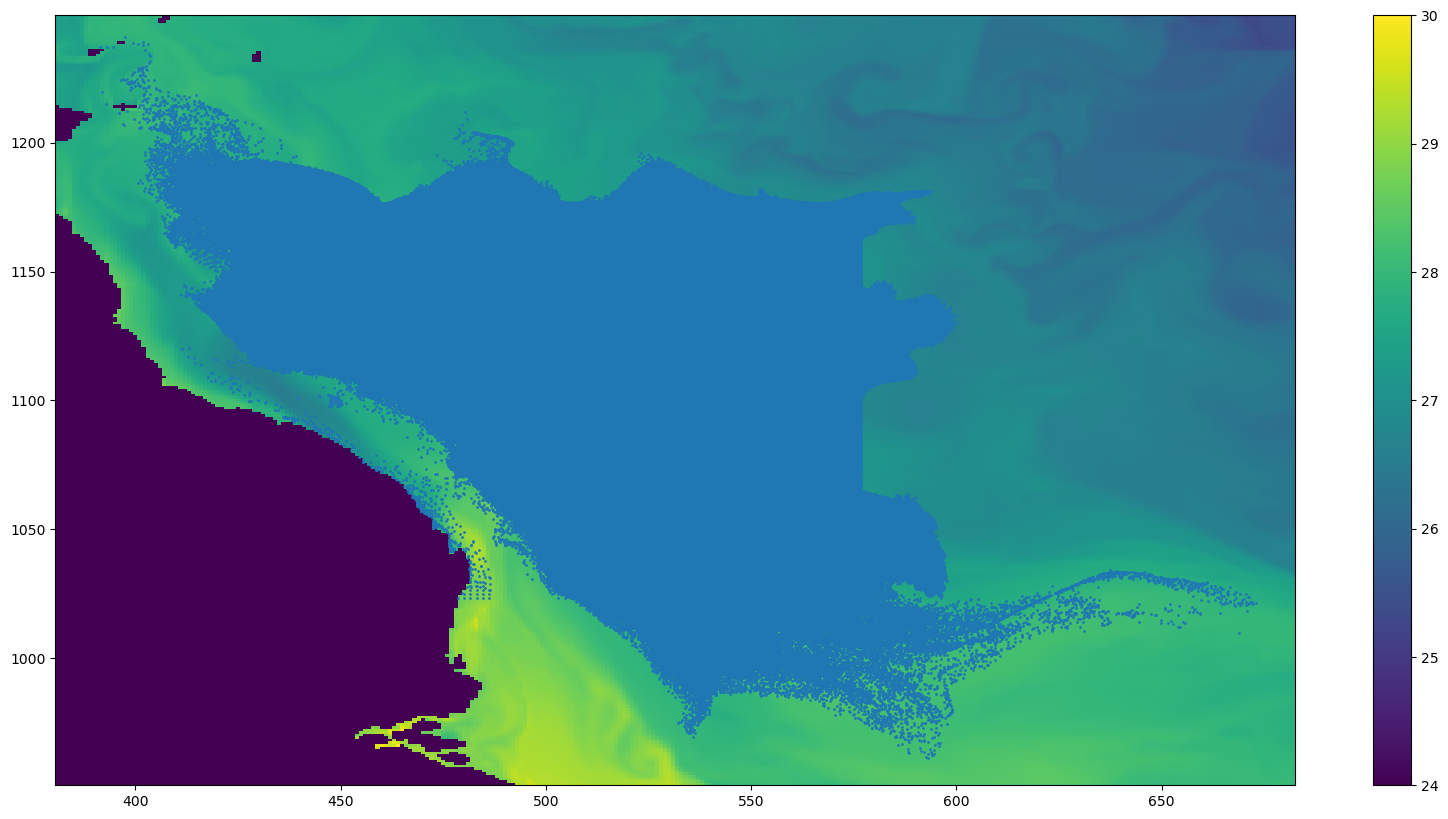

In [21]:
# --> superimposed sst with particles position
# s=1 set the scatter plot size
xplt = np.arange(coord[2], coord[3])
yplt = np.arange(coord[0], coord[1])

fig, ax = plt.subplots(1, figsize = (20, 10))
im = ax.pcolormesh(xplt, yplt, sst, vmin=24, vmax=30)
plt.colorbar(im)
ax.scatter(px, py, s=1)

(-62.558559053053685, -37.75765288084545)

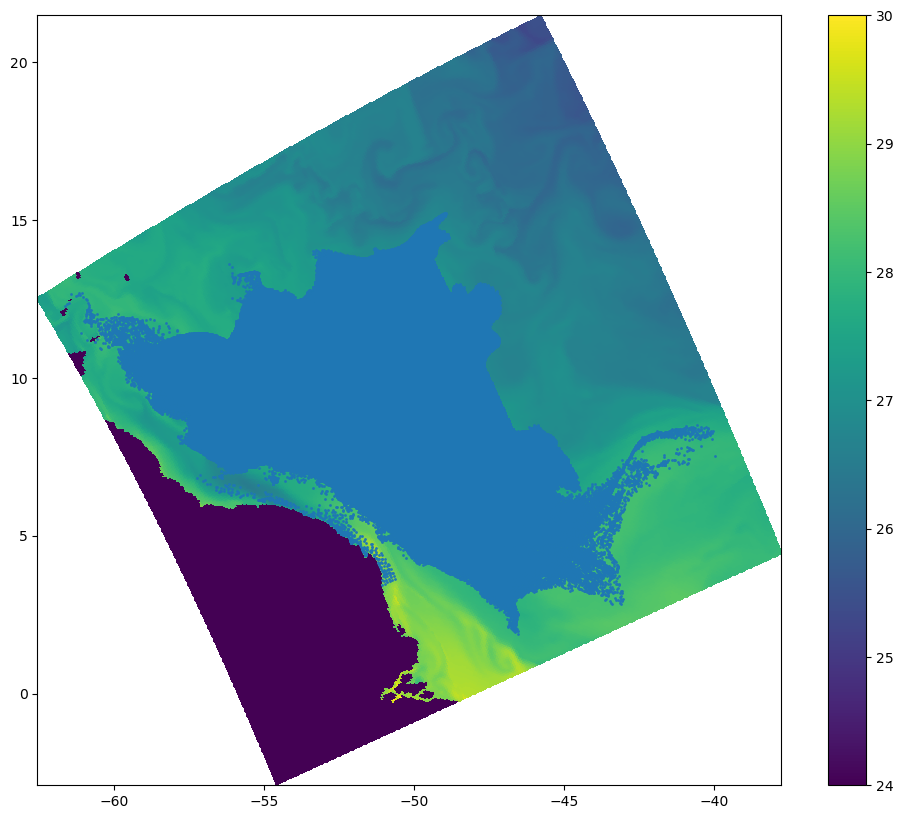

In [37]:
# --> Same plot in lon-lat coordinates
# longitude and latitude of Pyticles particles are present in netcdf file when
# key write_lonlat is activated
# lon, lat CROCO coordinates are in simul.x and simul.y
plon = ds.plon.sel(time=time).data
plat = ds.plat.sel(time=time).data

xplt = np.arange(coord[2], coord[3])
lon_plt = simul.x[coord[2]:coord[3], coord[0]:coord[1]].T
lat_plt = simul.y[coord[2]:coord[3], coord[0]:coord[1]].T

fig, ax = plt.subplots(1, figsize = (12, 10))
im = ax.pcolormesh(lon_plt, lat_plt, sst, vmin=24, vmax=30)
plt.colorbar(im)
ax.scatter(plon, plat, s=1)
# some particles at NaN have "0" coordinates
ax.set_xlim([np.nanmin(lon_plt), np.nanmax(lon_plt)])

## subsample partciles

as we can guess from particles patch above, Pyticles experiment uses continuous injection of partciles.
here we plot all particles including those that were just released. 

As a exercize we can select particles that where released at initial time step and then plot
their position after 25 pyticles time steps

In [38]:
# --> select intially released particles at t0

subsample = np.where(~np.isnan(ds.px.isel(time=0)))
px_now = ds.px.sel(time=time)
py_now = ds.py.sel(time=time)
px_sub = px_now[subsample]
py_sub = py_now[subsample]

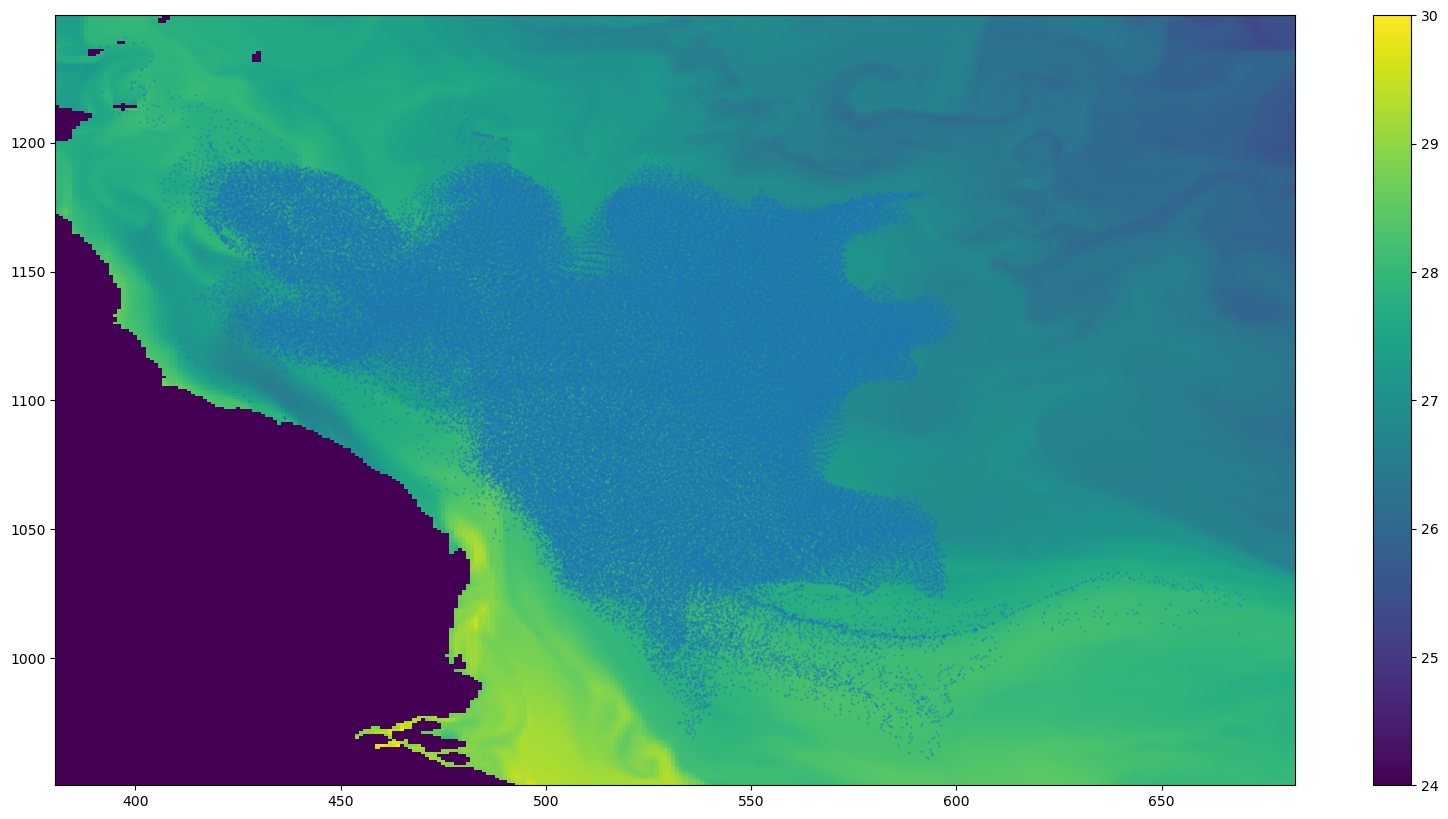

In [39]:
# --> plot particle cloud after 25 time steps
# well there are still a lot of particles but we start to see the impact of (sub)mesoscale dynamics
# at some locations

fig, ax = plt.subplots(1, figsize = (20, 10))
im = ax.pcolormesh(xplt, yplt, sst, vmin=24, vmax=30)
plt.colorbar(im)
ax.scatter(px_sub, py_sub, s=0.1)